In [11]:
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import shap
import seaborn as sns


In [2]:

# Specify the path to your JSON file
json_file_path = "../game_2020.json"  # Replace with the actual file path

# Initialize an empty list to store JSON objects
data = []

# Open and read the JSON file
with open(json_file_path, 'r') as json_file:
    data = json.load(json_file)

# Create a DataFrame from the list of JSON objects
df = pd.DataFrame(data)


In [3]:
# x is all columns except year, team_id and esports_id
# y is the outcome column
X = df.drop(['outcome', 'teamId', 'esportsGameId', 'leagueId'], axis=1)
y = df['outcome']


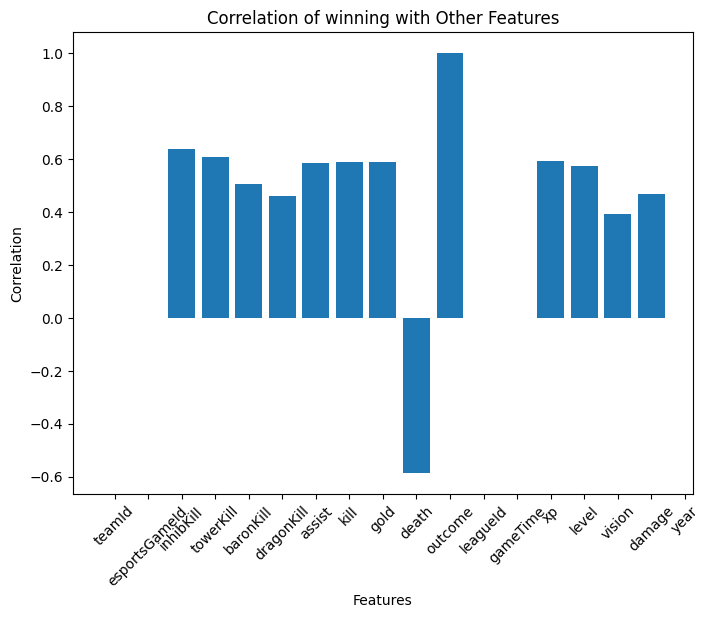

In [20]:
# Calculate the correlation between X and Y features
correlations = df.corr()['outcome']

# Create a bar chart to visualize the correlations
plt.figure(figsize=(8, 6))
plt.bar(correlations.index, correlations)
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.title(f'Correlation of winning with Other Features')
plt.xticks(rotation=45)
plt.show()

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust hyperparameters as needed

# Train the model on the training data
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [5]:
# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.817641228939544


In [6]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Assuming you have a list of feature names or column names
feature_names = list(X.columns)

# Create a DataFrame to display feature names and their importances
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by feature importance in descending order
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
print(importances_df)


       Feature  Importance
6         gold    0.169499
1    towerKill    0.126393
9           xp    0.122926
10       level    0.089851
5         kill    0.089823
7        death    0.078727
4       assist    0.061292
12      damage    0.061280
11      vision    0.055976
8     gameTime    0.055577
0    inhibKill    0.048864
3   dragonKill    0.028801
2    baronKill    0.010994
13        year    0.000000


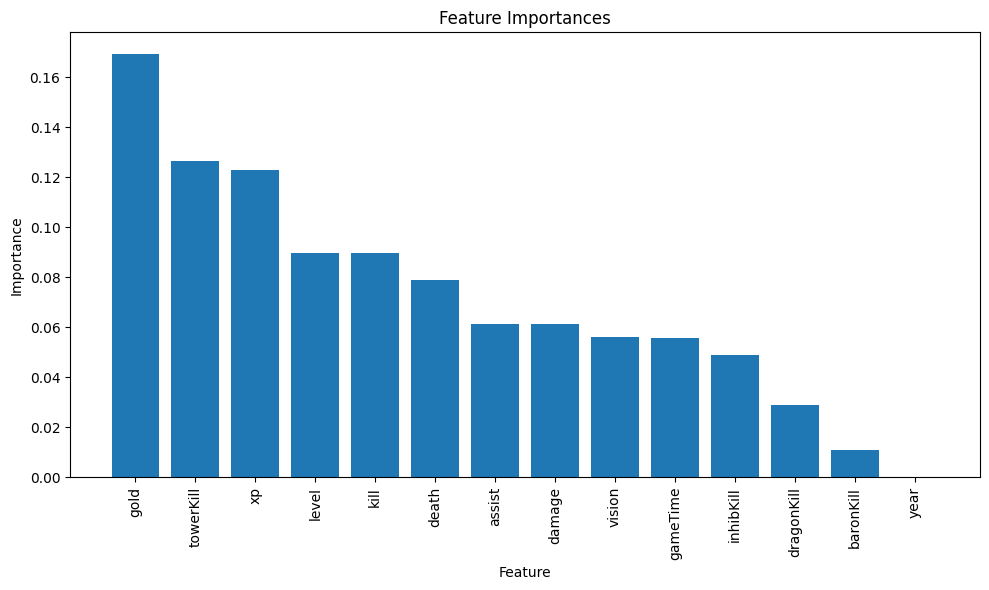

In [7]:
# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Show the chart
plt.tight_layout()
plt.show()

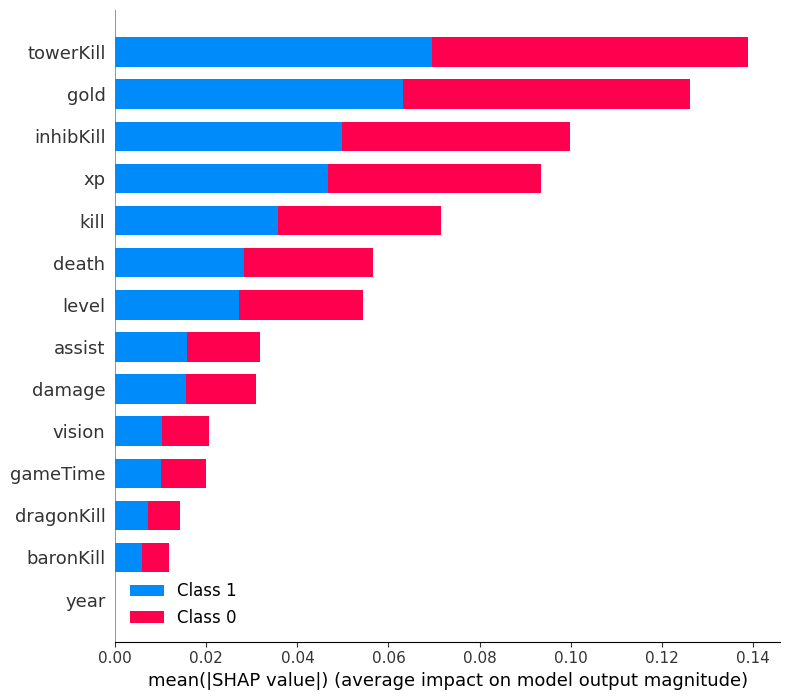

In [8]:
explainer = shap.Explainer(rf_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)